# Read multitone waveform `.mat` files

This notebook loads all `weightsN*.mat` files in the current folder and interprets them as:

- `fn`: tone offsets around the 875 MHz carrier.
- `weights`: complex tone weights (`rows = tones`, `columns = input power points`).
- `Pdc`: model-predicted DC values for the optimized weights.
- `inPwrVec`: input RF power vector in mW.

Filename convention: in `weightsNx.mat`, `x` is the number of tones.

In [52]:
from pathlib import Path
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from scipy.io import loadmat
except Exception as exc:
    raise ImportError(
        "Could not import scipy.io.loadmat. Install compatible numpy/scipy versions first."
    ) from exc

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True


In [53]:
BW_HZ = 20e6
FC_HZ = 875e6
DATA_DIR = Path(".")

print(f"Data dir: {DATA_DIR.resolve()}")
print(f"Assumed bandwidth: {BW_HZ/1e6:.1f} MHz, carrier: {FC_HZ/1e6:.1f} MHz")


Data dir: C:\Users\Calle\OneDrive\Documenten\GitHub\RF-waveform-optimization
Assumed bandwidth: 20.0 MHz, carrier: 875.0 MHz


In [54]:
def parse_n_tones(path: Path) -> int:
    match = re.search(r"weightsN(\d+)\.mat$", path.name)
    if not match:
        raise ValueError(f"Unexpected filename format: {path.name}")
    return int(match.group(1))


def _to_1d(x):
    return np.atleast_1d(np.asarray(x).squeeze())


def _to_2d(x):
    arr = np.asarray(x).squeeze()
    if arr.ndim == 0:
        return arr.reshape(1, 1)
    if arr.ndim == 1:
        return arr[:, None]
    return arr


def _normalize_fn_to_offsets_hz(fn_raw_hz, fc_hz, bw_hz):
    fn_raw_hz = np.asarray(fn_raw_hz, dtype=float).ravel()
    if fn_raw_hz.size == 0:
        raise ValueError("Empty fn array")

    # Some files store absolute RF frequencies (around carrier), others offsets.
    if np.nanmax(np.abs(fn_raw_hz)) > 2.0 * bw_hz:
        fn_offsets_hz = fn_raw_hz - float(fc_hz)
        fn_mode = "absolute_rf_hz"
    else:
        fn_offsets_hz = fn_raw_hz.copy()
        fn_mode = "offset_hz"

    return fn_offsets_hz, fn_mode


def load_waveform_file(path: Path) -> dict:
    mat = loadmat(path, squeeze_me=True)
    required = ["fn", "weights", "Pdc", "inPwrVec"]
    missing = [k for k in required if k not in mat]
    if missing:
        raise KeyError(f"{path.name} missing fields: {missing}")

    fn_raw = _to_1d(mat["fn"]).astype(float)
    fn, fn_mode = _normalize_fn_to_offsets_hz(fn_raw, FC_HZ, BW_HZ)
    weights = _to_2d(mat["weights"])
    pdc = _to_1d(mat["Pdc"]).astype(float)
    in_pwr_mw = _to_1d(mat["inPwrVec"]).astype(float)

    # If dimensions are transposed in file, align so rows map to tones.
    if weights.shape[0] != fn.size and weights.shape[1] == fn.size:
        weights = weights.T

    return {
        "file": path,
        "n_tones": parse_n_tones(path),
        "fn": fn,
        "fn_mode": fn_mode,
        "fn_raw": fn_raw,
        "weights": weights,
        "Pdc": pdc,
        "inPwrVec_mW": in_pwr_mw,
        "inPwrVec_dBm": 10 * np.log10(in_pwr_mw),
        "f_abs_Hz": FC_HZ + fn,
    }


In [55]:
mat_files = sorted(DATA_DIR.glob("weightsN*.mat"), key=parse_n_tones)
if not mat_files:
    raise FileNotFoundError("No files matching weightsN*.mat found in the current directory.")

waveforms = [load_waveform_file(p) for p in mat_files]
print(f"Loaded {len(waveforms)} files: {[w['file'].name for w in waveforms]}")


Loaded 4 files: ['weightsN4.mat', 'weightsN8.mat', 'weightsN16.mat', 'weightsN32.mat']


In [56]:
summary = pd.DataFrame(
    {
        "file": [w["file"].name for w in waveforms],
        "n_tones_from_name": [w["n_tones"] for w in waveforms],
        "fn_len": [w["fn"].size for w in waveforms],
        "weights_shape": [w["weights"].shape for w in waveforms],
        "n_input_powers": [w["inPwrVec_mW"].size for w in waveforms],
        "Pdc_len": [w["Pdc"].size for w in waveforms],
        "input_power_min_mW": [np.min(w["inPwrVec_mW"]) for w in waveforms],
        "input_power_max_mW": [np.max(w["inPwrVec_mW"]) for w in waveforms],
    }
)

summary


,file,n_tones_from_name,fn_len,weights_shape,n_input_powers,Pdc_len,input_power_min_mW,input_power_max_mW
0,weightsN4.mat,4,4,"(4, 16)",16,16,0.001,1.0
1,weightsN8.mat,8,8,"(8, 16)",16,16,0.001,1.0
2,weightsN16.mat,16,16,"(16, 16)",16,16,0.001,1.0
3,weightsN32.mat,32,32,"(32, 16)",16,16,0.001,1.0


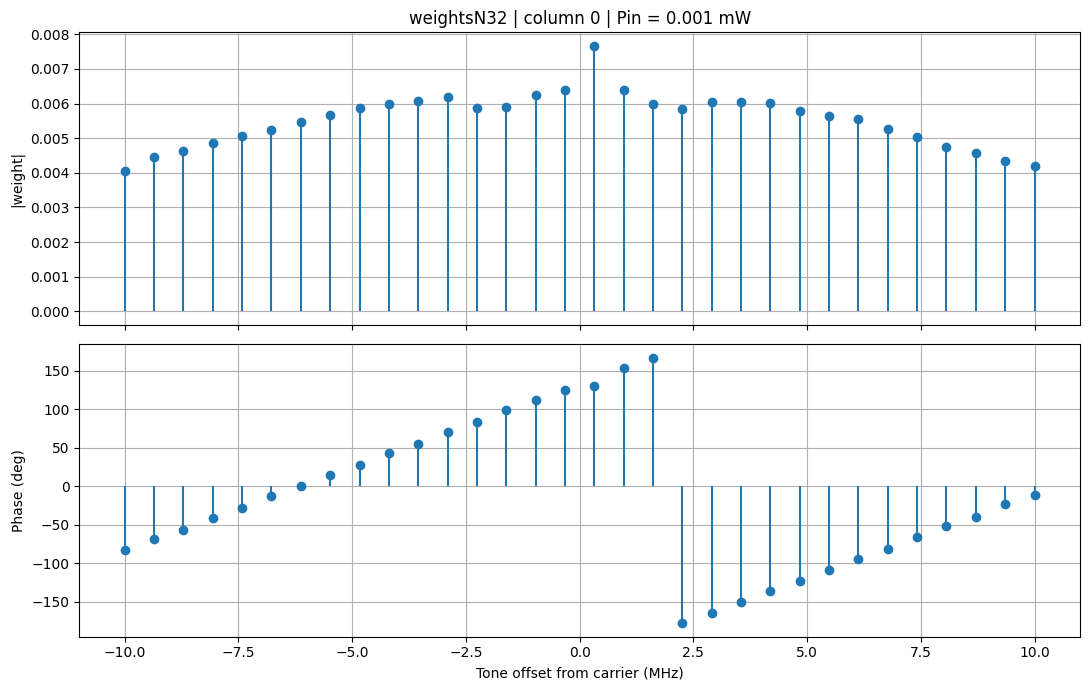

In [57]:
# Choose one waveform and one power-index column for detailed frequency-domain visualization.
selected_n_tones = 32
selected_power_idx = 0

wf = next((w for w in waveforms if w["n_tones"] == selected_n_tones), None)
if wf is None:
    available = [w["n_tones"] for w in waveforms]
    raise ValueError(f"N={selected_n_tones} not available. Choose from {available}")

selected_power_idx = int(np.clip(selected_power_idx, 0, wf["weights"].shape[1] - 1))
tone_offsets_mhz = wf["fn"] / 1e6
w_col = wf["weights"][:, selected_power_idx]

fig, ax = plt.subplots(2, 1, figsize=(11, 7), sharex=True)
ax[0].stem(tone_offsets_mhz, np.abs(w_col), basefmt=" ")
ax[0].set_ylabel("|weight|")
ax[0].set_title(
    f"weightsN{wf['n_tones']} | column {selected_power_idx} | "
    f"Pin = {wf['inPwrVec_mW'][selected_power_idx]:.3f} mW"
)

ax[1].stem(tone_offsets_mhz, np.angle(w_col, deg=True), basefmt=" ")
ax[1].set_xlabel("Tone offset from carrier (MHz)")
ax[1].set_ylabel("Phase (deg)")
plt.tight_layout()


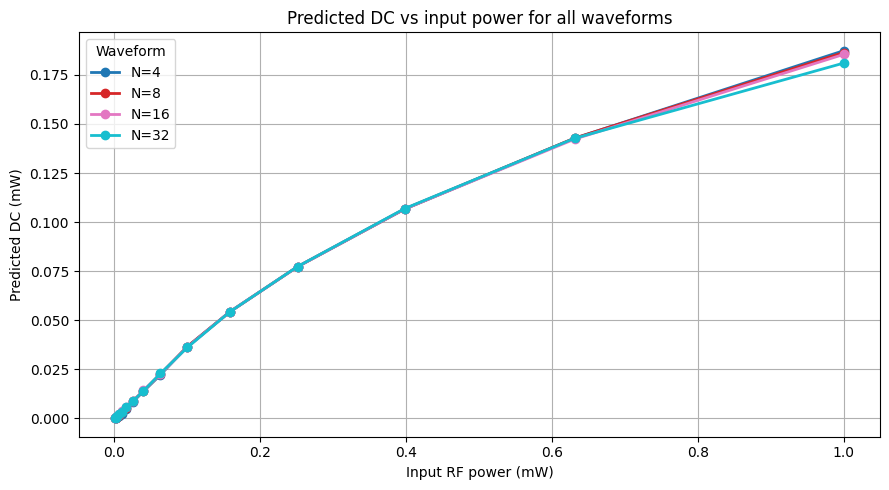

In [58]:
# All waveforms on one figure with different colors.
fig, ax = plt.subplots(figsize=(9, 5))
colors = plt.cm.tab10(np.linspace(0, 1, len(waveforms)))

for c, w in zip(colors, waveforms):
    ax.plot(
        w["inPwrVec_mW"],
        w["Pdc"],
        marker="o",
        color=c,
        linewidth=2,
        label=f"N={w['n_tones']}",
    )

ax.set_xlabel("Input RF power (mW)")
ax.set_ylabel("Predicted DC (mW)")
ax.set_title("Predicted DC vs input power for all waveforms")
ax.legend(title="Waveform", frameon=True)
plt.tight_layout()


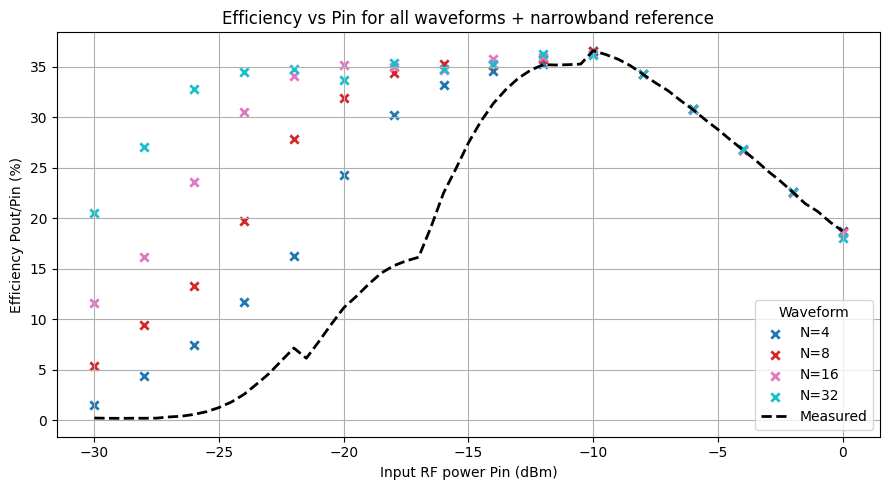

In [59]:
# Efficiency plot (assuming Pout = Pdc), with narrowband reference overlay.
fig, ax = plt.subplots(figsize=(9, 5))
colors = plt.cm.tab10(np.linspace(0, 1, len(waveforms)))

for c, w in zip(colors, waveforms):
    pin = np.asarray(w["inPwrVec_mW"], dtype=float)
    pout = np.asarray(w["Pdc"], dtype=float)
    eta = np.divide(pout, pin, out=np.full_like(pout, np.nan, dtype=float), where=pin > 0)
    ax.scatter(10*np.log10(pin), eta * 100.0, marker="x", color=c, linewidth=2, label=f"N={w['n_tones']}")

# Optional overlay: narrowband measured efficiency curve.
nb_csv = Path("harvester-chart-data.csv")
if nb_csv.exists():
    nb = pd.read_csv(nb_csv)
    required_cols = {"level_dbm", "efficiency"}
    if required_cols.issubset(nb.columns):
        nb = nb.sort_values("level_dbm")
        ax.plot(
            nb["level_dbm"].to_numpy(dtype=float),
            nb["efficiency"].to_numpy(dtype=float),
            color="black",
            linestyle="--",
            linewidth=2,
            label="Measured",
            zorder=5,
        )
    else:
        print(f"Skipping {nb_csv}: missing columns {required_cols}")
else:
    print(f"Skipping narrowband overlay: {nb_csv} not found")

ax.set_xlabel("Input RF power Pin (dBm)")
ax.set_ylabel("Efficiency Pout/Pin (%)")
ax.set_title("Efficiency vs Pin for all waveforms + narrowband reference")
ax.legend(title="Waveform", frameon=True)
plt.tight_layout()


## Notes

- Tones are expected between `-BW/2` and `+BW/2` with `BW = 20 MHz`.
- The notebook uses `fn` as baseband offsets in Hz.
- If a `.mat` file stores absolute RF frequencies in `fn`, they are auto-converted to offsets via `fn_offset = fn - 875e6`.
- Absolute tone frequencies are `875e6 + fn` (Hz).
- Each `weights` column corresponds to one sampled RF input power in `inPwrVec`.
- Efficiency in the added plot is computed as `Pdc / inPwrVec` (i.e., `Pout = Pdc`).
- The same plot overlays narrowband measured efficiency from `harvester-chart-data.csv` (`level_dbm` vs `efficiency`).
- If needed, change `selected_n_tones` and `selected_power_idx` to inspect another waveform or power point.


## Time-Domain Preprocessing For UHD Playback

This section reproduces the TX preprocessing used by `transmit_b210_dwell.py`:
- synthesize periodic IQ blocks in time domain,
- normalize average power to a target (`E[|x|^2]`),
- enforce `|IQ| <= 1.0` via additional scaling,
- export `.npz` IQ files for direct UHD playback.
- optionally oversample IQ at export-time so UHD script remains playout-only.


In [60]:
def synthesize_raw_periodic_block(fn_hz, weights_col, sample_rate_hz, block_size):
    fn_hz = np.asarray(fn_hz, dtype=float).ravel().copy()
    if fn_hz.size == 0:
        raise ValueError("fn_hz must contain at least one tone")

    bin_hz = float(sample_rate_hz) / float(block_size)
    nyquist_hz = 0.5 * float(sample_rate_hz)

    # +fs/2 and -fs/2 collapse to the same discrete-time frequency (Nyquist bin).
    # Shift +fs/2 inward by one bin so multitone sets keep unique peaks.
    pos_nyq = np.isclose(fn_hz, nyquist_hz, atol=0.25 * bin_hz, rtol=0.0)
    if np.any(pos_nyq):
        fn_hz[pos_nyq] = nyquist_hz - bin_hz

    bins = np.rint((fn_hz / sample_rate_hz) * block_size).astype(np.int64)
    bins_mod = np.mod(bins, int(block_size))
    if np.unique(bins_mod).size != bins_mod.size:
        n_dup = int(bins_mod.size - np.unique(bins_mod).size)
        raise ValueError(
            f"Tone-to-bin quantization produced {n_dup} duplicate bin(s). "
            f"Increase block_size or adjust tone offsets."
        )

    quantized_fn_hz = bins.astype(np.float64) * (sample_rate_hz / block_size)
    freq_error_hz = quantized_fn_hz - fn_hz

    n = np.arange(block_size, dtype=np.float64)
    phase = (2j * np.pi / block_size) * np.outer(n, bins)
    raw = np.exp(phase) @ np.asarray(weights_col, dtype=np.complex128)

    raw_power = float(np.mean(np.abs(raw) ** 2))
    raw_peak = float(np.max(np.abs(raw)))
    if raw_power <= 0 or raw_peak <= 0:
        raise ValueError("Synthesis produced zero signal")

    return {
        "raw": raw,
        "fn_hz_used": fn_hz,
        "bins": bins,
        "quantized_fn_hz": quantized_fn_hz,
        "freq_error_hz": freq_error_hz,
        "raw_peak": raw_peak,
        "raw_power": raw_power,
    }


def scale_raw_periodic_block(raw_info, target_power=0.8, max_amplitude=1.0):
    if target_power <= 0:
        raise ValueError("target_power must be > 0")
    if max_amplitude <= 0:
        raise ValueError("max_amplitude must be > 0")

    raw = np.asarray(raw_info["raw"], dtype=np.complex128)
    raw_power = float(raw_info["raw_power"])
    raw_peak = float(raw_info["raw_peak"])

    max_feasible_power = (max_amplitude / raw_peak) ** 2 * raw_power
    final_target_power = min(float(target_power), float(max_feasible_power))

    scale = np.sqrt(final_target_power / raw_power)
    iq = raw * scale
    final_peak = float(np.max(np.abs(iq)))

    # Numerical safety guard.
    if final_peak > max_amplitude:
        guard = (max_amplitude * (1.0 - 1e-7)) / final_peak
        iq = iq * guard
        scale *= guard
        final_peak = float(np.max(np.abs(iq)))

    final_power = float(np.mean(np.abs(iq) ** 2))
    peak_limited = final_target_power < target_power - 1e-12

    return {
        "iq": iq.astype(np.complex64),
        "fn_hz_used": raw_info["fn_hz_used"],
        "bins": raw_info["bins"],
        "quantized_fn_hz": raw_info["quantized_fn_hz"],
        "freq_error_hz": raw_info["freq_error_hz"],
        "scale": float(scale),
        "raw_peak": raw_peak,
        "raw_power": raw_power,
        "final_peak": float(final_peak),
        "final_power": float(final_power),
        "peak_limited": bool(peak_limited),
        "max_feasible_power": float(max_feasible_power),
        "target_power": float(final_target_power),
    }



def oversample_periodic_iq(samples, sample_rate_hz, factor):
    factor = int(factor)
    if factor <= 1:
        return np.asarray(samples, dtype=np.complex64), float(sample_rate_hz)

    x = np.asarray(samples, dtype=np.complex64).ravel()
    n = int(x.size)
    if n < 2:
        raise ValueError("Need at least 2 IQ samples for oversampling")

    m = int(n * factor)
    x_f = np.fft.fftshift(np.fft.fft(x, n=n))
    pad_total = m - n
    pad_left = pad_total // 2
    pad_right = pad_total - pad_left
    y_f = np.pad(x_f, (pad_left, pad_right), mode="constant")

    # NumPy ifft has 1/M scaling; multiply by M/N to preserve amplitude.
    y = np.fft.ifft(np.fft.ifftshift(y_f), n=m) * float(factor)
    return y.astype(np.complex64), float(sample_rate_hz) * float(factor)


In [61]:
# Export IQ blocks for UHD replay with one common average power across all files.
SAMPLE_RATE_HZ = 20e6
TX_OVERSAMPLE = 2                  # Export-time oversampling factor for UHD playout
BLOCK_SIZE = 65536
TARGET_POWER_REQUESTED = 0.8
MAX_AMPLITUDE = 1.0
EQUAL_POWER_TOL = 1e-6

# Choose which multitone files/columns to export.
EXPORT_TONES = [4, 8, 16, 32]      # subset of available N values
EXPORT_COLUMNS = [0]               # list or "all"

# Optional narrowband export (maps to --tone 0 in UHD script).
INCLUDE_NARROWBAND = True
NARROWBAND_OFFSET_HZ = 100e3

EXPORT_DIR = Path("tx_iq")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)


if TX_OVERSAMPLE < 1 or int(TX_OVERSAMPLE) != TX_OVERSAMPLE:
    raise ValueError("TX_OVERSAMPLE must be a positive integer")
TX_OVERSAMPLE = int(TX_OVERSAMPLE)


def _resolve_cols(selector, n_cols):
    if isinstance(selector, str) and selector.lower() == "all":
        return list(range(n_cols))
    cols = [int(c) for c in selector]
    for c in cols:
        if c < 0 or c >= n_cols:
            raise ValueError(f"Column index {c} out of range [0, {n_cols - 1}]")
    return list(dict.fromkeys(cols))


candidates = []

for wf in waveforms:
    if wf["n_tones"] not in EXPORT_TONES:
        continue

    if np.max(np.abs(np.asarray(wf["fn"], dtype=float))) > (SAMPLE_RATE_HZ / 2 + 1e-6):
        raise ValueError(
            f"Tone offsets for {wf['file'].name} exceed Nyquist after normalization. "
            f"Got range [{np.min(wf['fn']):.3f}, {np.max(wf['fn']):.3f}] Hz at fs={SAMPLE_RATE_HZ:.3f} Hz"
        )

    cols = _resolve_cols(EXPORT_COLUMNS, wf["weights"].shape[1])
    for col in cols:
        raw_info = synthesize_raw_periodic_block(
            fn_hz=wf["fn"],
            weights_col=wf["weights"][:, col],
            sample_rate_hz=SAMPLE_RATE_HZ,
            block_size=BLOCK_SIZE,
        )

        candidates.append(
            {
                "mode": "multitone",
                "source": wf["file"].name,
                "n_tones": int(wf["n_tones"]),
                "column": int(col),
                "pin_mW": float(wf["inPwrVec_mW"][col]) if "inPwrVec_mW" in wf else np.nan,
                "tone_offsets_requested_hz": np.asarray(wf["fn"], dtype=float),
                "raw_info": raw_info,
            }
        )

if INCLUDE_NARROWBAND:
    raw_nb = synthesize_raw_periodic_block(
        fn_hz=np.array([NARROWBAND_OFFSET_HZ], dtype=float),
        weights_col=np.array([1.0 + 0.0j], dtype=np.complex128),
        sample_rate_hz=SAMPLE_RATE_HZ,
        block_size=BLOCK_SIZE,
    )

    candidates.append(
        {
            "mode": "narrowband",
            "source": "synthetic",
            "n_tones": 0,
            "column": -1,
            "pin_mW": np.nan,
            "tone_offsets_requested_hz": np.array([float(NARROWBAND_OFFSET_HZ)]),
            "raw_info": raw_nb,
        }
    )

if len(candidates) == 0:
    raise RuntimeError("No candidates selected for export.")

# Compute one common feasible power for all signals before oversampling.
max_feasible_per_signal = [
    (MAX_AMPLITUDE / c["raw_info"]["raw_peak"]) ** 2 * c["raw_info"]["raw_power"]
    for c in candidates
]
common_target_power = min(float(TARGET_POWER_REQUESTED), float(np.min(max_feasible_per_signal)))

if common_target_power < TARGET_POWER_REQUESTED - 1e-12:
    print(
        f"Requested target power {TARGET_POWER_REQUESTED:.6g} cannot satisfy |IQ| <= {MAX_AMPLITUDE:.6g} for all signals."
    )
    print(f"Using common feasible power instead: {common_target_power:.6g}")
else:
    print(f"Using requested common target power: {common_target_power:.6g}")

records = []

for c in candidates:
    synth = scale_raw_periodic_block(
        raw_info=c["raw_info"],
        target_power=common_target_power,
        max_amplitude=MAX_AMPLITUDE,
    )

    iq_tx = np.asarray(synth["iq"], dtype=np.complex64)
    tx_rate_hz = float(SAMPLE_RATE_HZ)

    if TX_OVERSAMPLE > 1:
        iq_tx, tx_rate_hz = oversample_periodic_iq(iq_tx, tx_rate_hz, TX_OVERSAMPLE)

    post_scale = 1.0
    tx_peak = float(np.max(np.abs(iq_tx)))
    if tx_peak > MAX_AMPLITUDE + 1e-6:
        post_scale = (MAX_AMPLITUDE * (1.0 - 1e-7)) / tx_peak
        iq_tx = (iq_tx * post_scale).astype(np.complex64)
        tx_peak = float(np.max(np.abs(iq_tx)))

    tx_power = float(np.mean(np.abs(iq_tx) ** 2))

    if c["mode"] == "multitone":
        out_path = EXPORT_DIR / f"iq_N{c['n_tones']}_col{c['column']}.npz"
    else:
        out_path = EXPORT_DIR / f"iq_N0_offset_{int(round(c['tone_offsets_requested_hz'][0]))}Hz.npz"

    np.savez(
        out_path,
        iq=iq_tx,
        sample_rate_hz=float(tx_rate_hz),
        sample_rate_source_hz=float(SAMPLE_RATE_HZ),
        oversample_factor=int(TX_OVERSAMPLE),
        center_freq_hz=float(FC_HZ),
        block_size=int(iq_tx.size),
        block_size_source=int(BLOCK_SIZE),
        n_tones=int(c["n_tones"]),
        column=int(c["column"]),
        tone_offsets_hz=np.asarray(synth["fn_hz_used"], dtype=float),
        tone_offsets_requested_hz=np.asarray(c["tone_offsets_requested_hz"], dtype=float),
        quantized_tone_offsets_hz=np.asarray(synth["quantized_fn_hz"], dtype=float),
        freq_error_hz=np.asarray(synth["freq_error_hz"], dtype=float),
        target_power=float(common_target_power),
        target_power_requested=float(TARGET_POWER_REQUESTED),
        max_amplitude=float(MAX_AMPLITUDE),
        scale=float(synth["scale"] * post_scale),
        raw_power=float(synth["raw_power"]),
        final_power=float(tx_power),
        raw_peak=float(synth["raw_peak"]),
        final_peak=float(tx_peak),
        peak_limited=bool(synth["peak_limited"]),
        max_feasible_power=float(synth["max_feasible_power"]),
    )

    pin_mw = c["pin_mW"]
    pin_dbm = 10 * np.log10(pin_mw) if pin_mw > 0 else np.nan

    records.append(
        {
            "mode": c["mode"],
            "source": c["source"],
            "n_tones": int(c["n_tones"]),
            "column": int(c["column"]),
            "pin_mW": pin_mw,
            "pin_dBm": pin_dbm,
            "tx_sample_rate_hz": tx_rate_hz,
            "oversample_factor": TX_OVERSAMPLE,
            "samples": int(iq_tx.size),
            "raw_power": synth["raw_power"],
            "final_power": tx_power,
            "raw_peak": synth["raw_peak"],
            "final_peak": tx_peak,
            "peak_limited": synth["peak_limited"],
            "max_feasible_power": synth["max_feasible_power"],
            "max_abs_freq_error_hz": float(np.max(np.abs(synth["freq_error_hz"]))),
            "iq_file": str(out_path),
        }
    )

export_summary = pd.DataFrame(records)
if not export_summary.empty:
    export_summary = export_summary.sort_values(["mode", "n_tones", "column"]).reset_index(drop=True)

# Enforce equal-power condition (within tolerance).
power_span = float(export_summary["final_power"].max() - export_summary["final_power"].min())
print(f"Exported {len(export_summary)} IQ file(s) to: {EXPORT_DIR.resolve()}")
print(f"TX oversample factor: {TX_OVERSAMPLE}x")
print(f"Common target power used: {common_target_power:.6g}")
print(f"Final power span across exported files: {power_span:.6g}")
if power_span > EQUAL_POWER_TOL:
    raise RuntimeError(
        f"Equal-power condition failed: span={power_span:.6g} exceeds tolerance {EQUAL_POWER_TOL:.6g}"
    )

export_summary


Requested target power 0.8 cannot satisfy |IQ| <= 1 for all signals.
Using common feasible power instead: 0.0362105
Exported 5 IQ file(s) to: C:\Users\Calle\OneDrive\Documenten\GitHub\RF-waveform-optimization\tx_iq
TX oversample factor: 2x
Common target power used: 0.0362105
Final power span across exported files: 1.11759e-08


,mode,source,n_tones,column,pin_mW,pin_dBm,tx_sample_rate_hz,oversample_factor,samples,raw_power,final_power,raw_peak,final_peak,peak_limited,max_feasible_power,max_abs_freq_error_hz,iq_file
0,multitone,weightsN4.mat,4,0,0.001,-30.0,40000000.0,2,131072,0.001,0.036211,0.062821,0.378028,False,0.253388,101.725260,tx_iq\iq_N4_col0.npz
1,multitone,weightsN8.mat,8,0,0.001,-30.0,40000000.0,2,131072,0.001,0.036211,0.079859,0.489532,False,0.156801,130.789621,tx_iq\iq_N8_col0.npz
2,multitone,weightsN16.mat,16,0,0.001,-30.0,40000000.0,2,131072,0.001,0.036211,0.124745,0.750658,False,0.064261,142.415365,tx_iq\iq_N16_col0.npz
3,multitone,weightsN32.mat,32,0,0.001,-30.0,40000000.0,2,131072,0.001,0.036211,0.166181,1.000000,False,0.036211,147.665701,tx_iq\iq_N32_col0.npz
4,narrowband,synthetic,0,-1,NaN,NaN,40000000.0,2,131072,1.000,0.036211,1.000000,0.190291,False,1.000000,97.656250,tx_iq\iq_N0_offset_100000Hz.npz


,iq_file,samples,avg_power,peak_amp,peak_power,crest_db
0,tx_iq\iq_N4_col0.npz,131072,0.036211,0.378028,0.142906,5.962142e+00
1,tx_iq\iq_N8_col0.npz,131072,0.036211,0.489532,0.239642,8.207281e+00
2,tx_iq\iq_N16_col0.npz,131072,0.036211,0.750658,0.563487,1.192049e+01
3,tx_iq\iq_N32_col0.npz,131072,0.036211,1.000000,1.000000,1.441165e+01
4,tx_iq\iq_N0_offset_100000Hz.npz,131072,0.036211,0.190291,0.036211,2.308345e-07


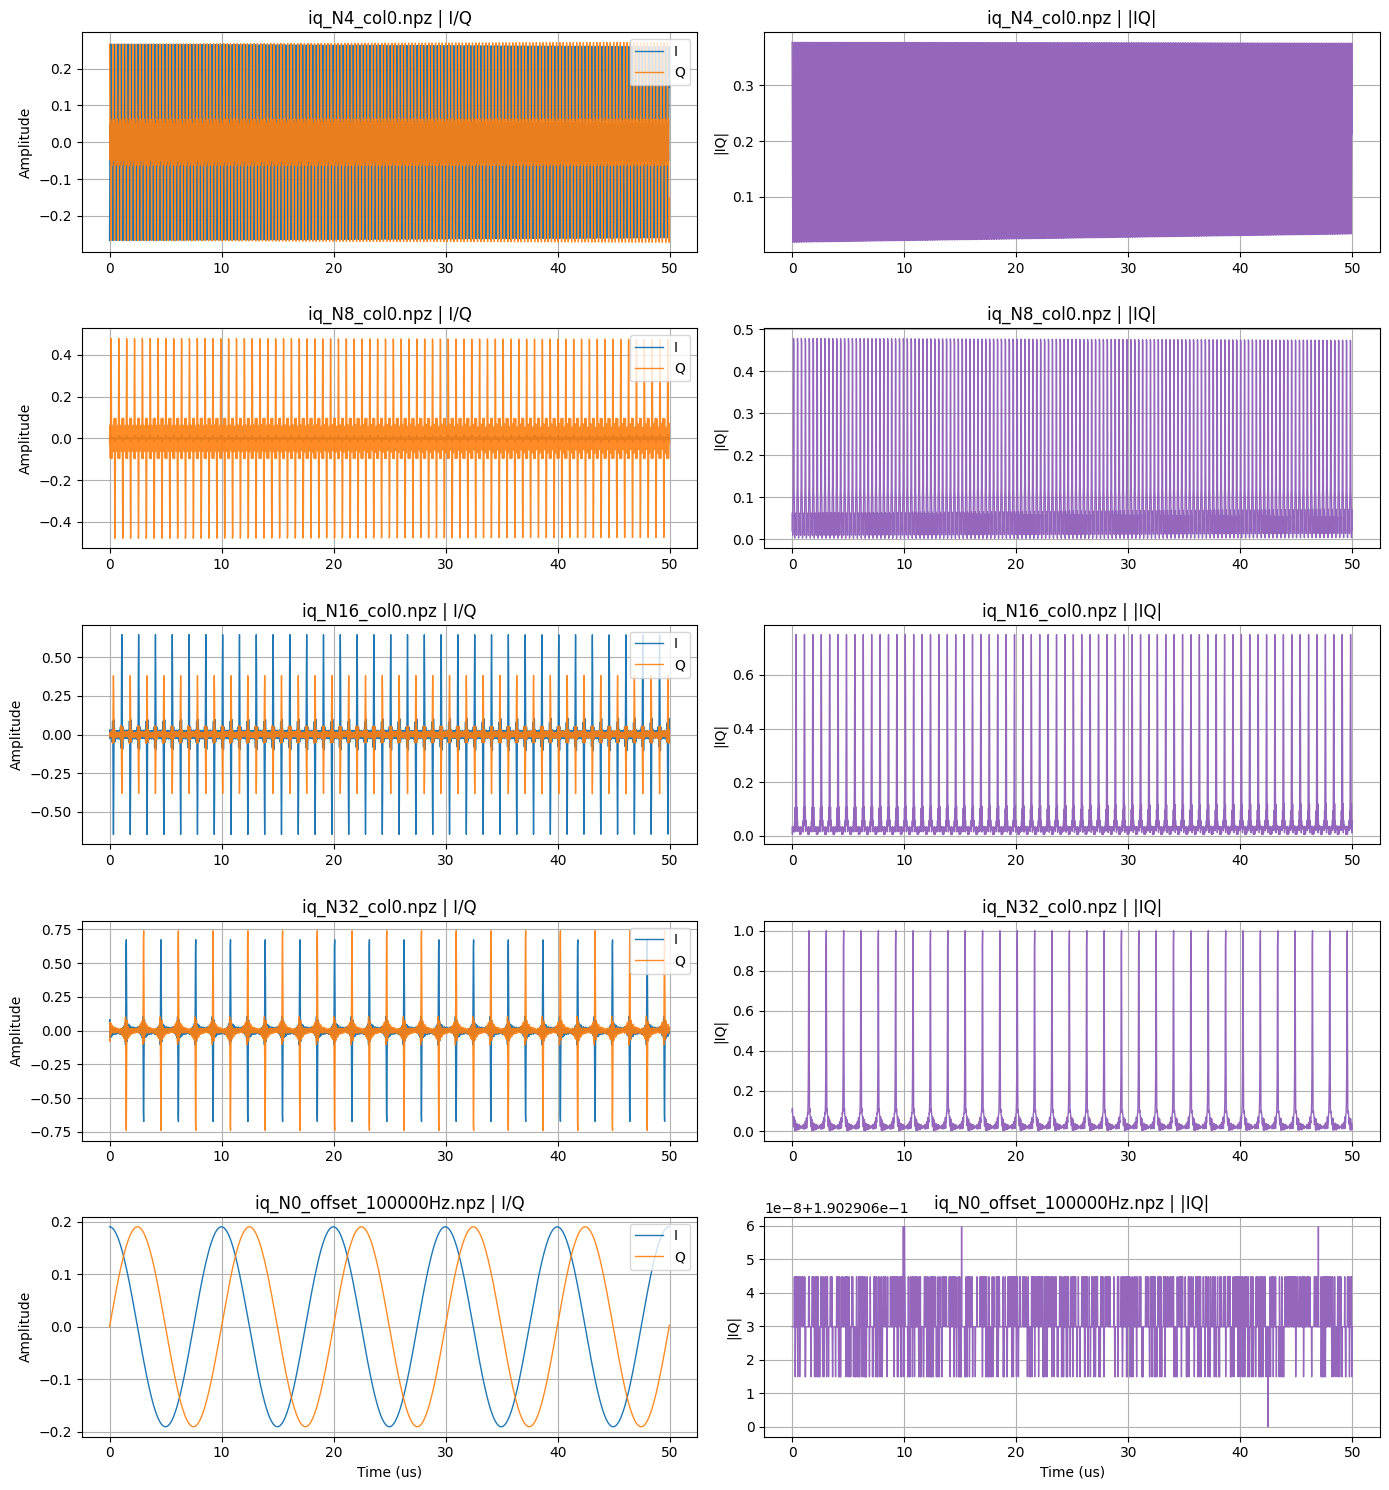

In [62]:
# Time-domain preview for all exported IQ files.
if export_summary.empty:
    raise RuntimeError("No exported IQ files found. Run the export cell first.")

N_SHOW = 2000
n_files = len(export_summary)

fig, axes = plt.subplots(
    n_files,
    2,
    figsize=(14, max(3.0 * n_files, 5.0)),
    squeeze=False,
    sharex=False,
)

metrics = []

for row_idx, (_, row) in enumerate(export_summary.iterrows()):
    iq_file = Path(row["iq_file"])

    with np.load(iq_file, allow_pickle=False) as data:
        iq = np.asarray(data["iq"]).squeeze().astype(np.complex64)
        fs_hz = float(np.asarray(data["sample_rate_hz"]).squeeze()) if "sample_rate_hz" in data.files else SAMPLE_RATE_HZ

    n_show = min(N_SHOW, iq.size)
    t_us = (np.arange(n_show) / fs_hz) * 1e6

    i_sig = iq[:n_show].real
    q_sig = iq[:n_show].imag
    mag = np.abs(iq[:n_show])

    avg_power = float(np.mean(np.abs(iq) ** 2))
    peak_amp = float(np.max(np.abs(iq)))
    peak_power = peak_amp ** 2
    crest_db = 10 * np.log10(peak_power / avg_power)

    metrics.append(
        {
            "iq_file": str(iq_file),
            "samples": int(iq.size),
            "avg_power": avg_power,
            "peak_amp": peak_amp,
            "peak_power": peak_power,
            "crest_db": crest_db,
        }
    )

    ax_iq = axes[row_idx, 0]
    ax_mag = axes[row_idx, 1]

    ax_iq.plot(t_us, i_sig, label="I", linewidth=1.0)
    ax_iq.plot(t_us, q_sig, label="Q", linewidth=1.0, alpha=0.9)
    ax_iq.set_ylabel("Amplitude")
    ax_iq.set_title(f"{iq_file.name} | I/Q")
    ax_iq.grid(True)
    ax_iq.legend(loc="upper right")

    ax_mag.plot(t_us, mag, color="tab:purple", linewidth=1.0)
    ax_mag.set_ylabel("|IQ|")
    ax_mag.set_title(f"{iq_file.name} | |IQ|")
    ax_mag.grid(True)

    if row_idx == n_files - 1:
        ax_iq.set_xlabel("Time (us)")
        ax_mag.set_xlabel("Time (us)")

plt.tight_layout()

time_domain_summary = pd.DataFrame(metrics)
time_domain_summary


## FFT Preview For Exported IQ Files

This section plots the complex baseband FFT (centered at DC) for each exported `.npz` file.


,iq_file,fft_size,peak_freq_MHz,peak_mag_dBFS,median_mag_dBFS
0,tx_iq\iq_N4_col0.npz,65536,-10.000000,-20.892496,-213.996082
1,tx_iq\iq_N8_col0.npz,65536,-7.142944,-23.667075,-214.342359
2,tx_iq\iq_N16_col0.npz,65536,-2.000122,-25.129469,-213.462336
3,tx_iq\iq_N32_col0.npz,65536,0.322266,-28.135760,-211.458322
4,tx_iq\iq_N0_offset_100000Hz.npz,65536,0.100098,-14.411652,-240.000000


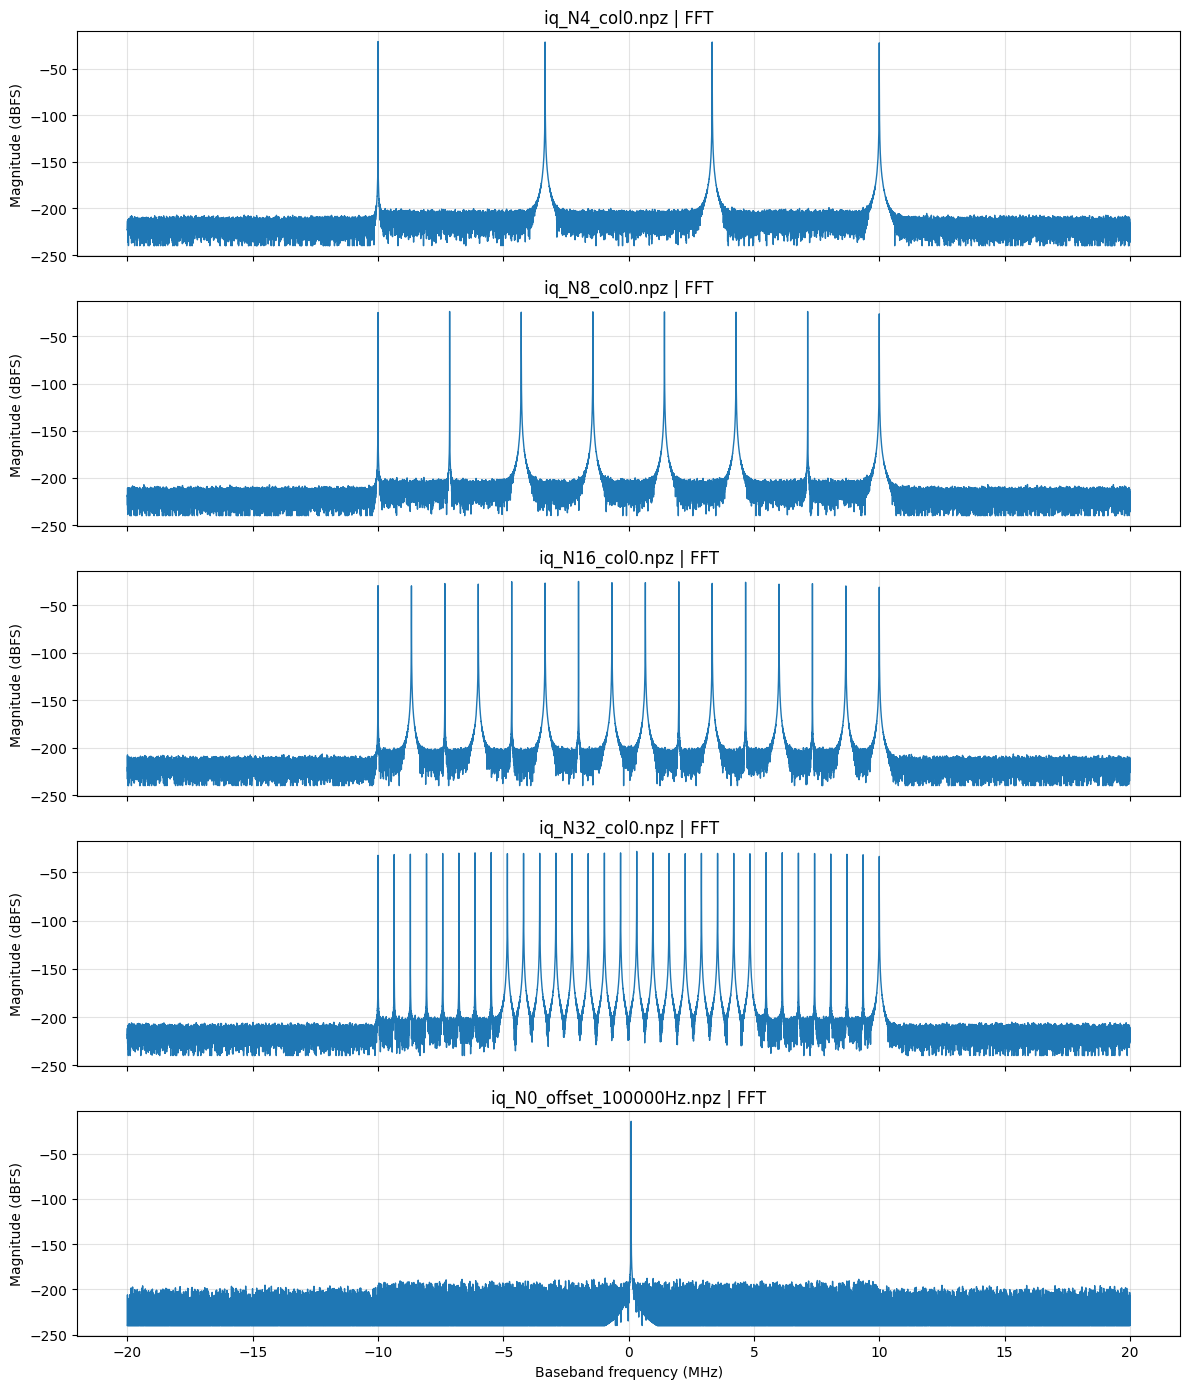

In [63]:
# FFT preview for all exported IQ files.
if export_summary.empty:
    raise RuntimeError("No exported IQ files found. Run the export cell first.")

FFT_SIZE = 65536
n_files = len(export_summary)

fig, axes = plt.subplots(
    n_files,
    1,
    figsize=(12, max(2.8 * n_files, 4.0)),
    squeeze=False,
    sharex=True,
)

fft_metrics = []

for row_idx, (_, row) in enumerate(export_summary.iterrows()):
    iq_file = Path(row["iq_file"])

    with np.load(iq_file, allow_pickle=False) as data:
        iq = np.asarray(data["iq"]).squeeze().astype(np.complex64)
        fs_hz = float(np.asarray(data["sample_rate_hz"]).squeeze()) if "sample_rate_hz" in data.files else SAMPLE_RATE_HZ

    nfft = int(FFT_SIZE)
    n_use = min(iq.size, nfft)
    segment = np.zeros(nfft, dtype=np.complex64)
    segment[:n_use] = iq[:n_use]

    window = np.hanning(nfft).astype(np.float64)
    spec = np.fft.fftshift(np.fft.fft(segment * window, n=nfft))
    mag = np.abs(spec) / max(float(window.sum()), 1e-12)
    mag_db = 20.0 * np.log10(np.maximum(mag, 1e-12))
    f_mhz = np.fft.fftshift(np.fft.fftfreq(nfft, d=1.0 / fs_hz)) / 1e6

    ax = axes[row_idx, 0]
    ax.plot(f_mhz, mag_db, linewidth=1.0)
    ax.set_title(f"{iq_file.name} | FFT")
    ax.set_ylabel("Magnitude (dBFS)")
    ax.grid(True, alpha=0.35)

    peak_idx = int(np.argmax(mag_db))
    fft_metrics.append(
        {
            "iq_file": str(iq_file),
            "fft_size": nfft,
            "peak_freq_MHz": float(f_mhz[peak_idx]),
            "peak_mag_dBFS": float(mag_db[peak_idx]),
            "median_mag_dBFS": float(np.median(mag_db)),
        }
    )

axes[-1, 0].set_xlabel("Baseband frequency (MHz)")
plt.tight_layout()

fft_summary = pd.DataFrame(fft_metrics)
fft_summary


In [64]:
# Hard checks before UHD replay.
viol_peak = export_summary[export_summary["final_peak"] > 1.0 + 1e-6]
viol_power = export_summary[np.isnan(export_summary["final_power"]) | (export_summary["final_power"] <= 0)]

# Equal average power check.
POWER_EQ_TOL_REL = 1e-4
if len(export_summary) > 0:
    p_ref = float(export_summary["final_power"].iloc[0])
    rel_err = np.abs(export_summary["final_power"] - p_ref) / max(p_ref, 1e-12)
    viol_equal = export_summary[rel_err > POWER_EQ_TOL_REL]
else:
    viol_equal = export_summary.iloc[0:0]

print(f"Peak violations (>1.0): {len(viol_peak)}")
print(f"Invalid power rows: {len(viol_power)}")
print(f"Equal-power violations (rel tol {POWER_EQ_TOL_REL:.1e}): {len(viol_equal)}")

if len(viol_peak) > 0:
    display(viol_peak[["iq_file", "final_peak", "final_power", "peak_limited"]])
if len(viol_equal) > 0:
    display(viol_equal[["iq_file", "final_power"]])


Peak violations (>1.0): 0
Invalid power rows: 0
Equal-power violations (rel tol 1.0e-04): 0
